In [82]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

## Load data and clean them
Here null and NaN records and duplicated values are removed

In [83]:

df = pd.read_csv('sample_data/marketing_data.csv')
df.dropna()
df.drop_duplicates(inplace=True)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Describing the Data
Selected PURCHASES_FREQUENCY, TENURE and PRC_FULL_PAYMENT since those variables are identified as aligned to the RFM (Recency, Frequency and Monetory) Analysis

In [84]:
df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].describe(include='all')

,PURCHASES_FREQUENCY,TENURE,PRC_FULL_PAYMENT
count,8950.000000,8950.000000,8950.000000
mean,0.490351,11.517318,0.153715
std,0.401371,1.338331,0.292499
min,0.000000,6.000000,0.000000
25%,0.083333,12.000000,0.000000
50%,0.500000,12.000000,0.000000
75%,0.916667,12.000000,0.142857
max,1.000000,12.000000,1.000000


## Scaling and Normalizing data and plotting.

This scaling and normalizing is important because features often have different units and scales of measurement, which can lead to biases in models that rely on distance calculations or gradient descent optimization. By standardizing the range of features, we can help algorithms to converge more quickly and perform more consistently.

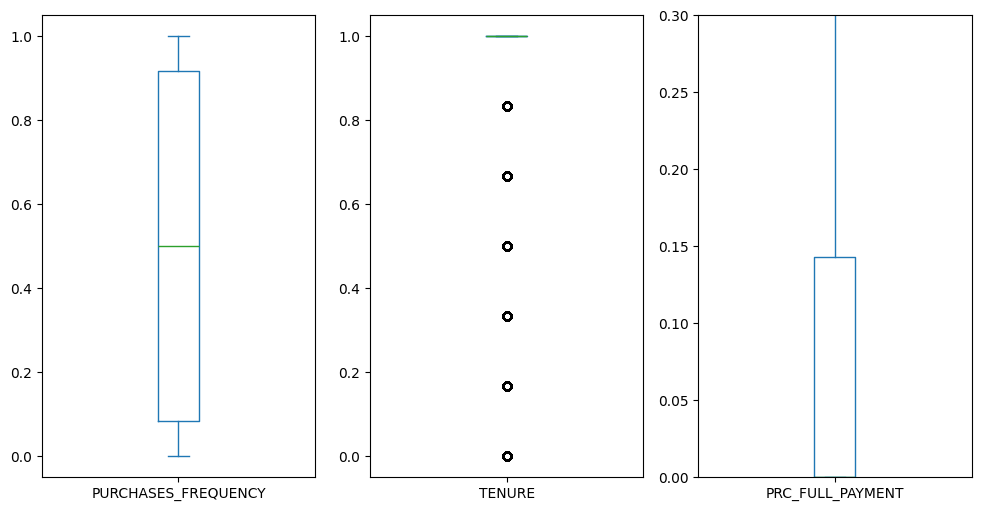

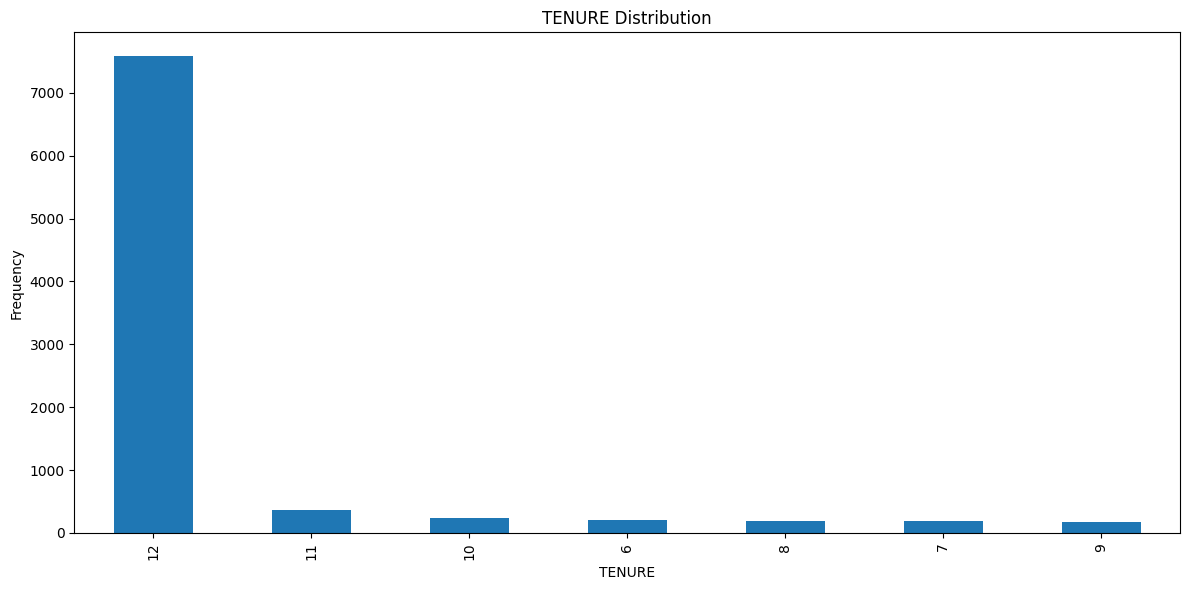

In [85]:
# Scaling - Normalizing the data to be between 0 and 1
df_scaled = (df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']] - df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].min()) / (df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].max() - df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].min())

# Plotting scaled data
df_scaled.plot(kind='box', subplots=True, layout=(1,3), figsize=(12, 6))

# Adjusting ylim if necessary (example for 'PRC_FULL_PAYMENT')
plt.subplot(1, 3, 3) # Adjust the index accordingly
plt.ylim(0, 0.3) # Set the limit to focus on the main cluster of data

# If TENURE is a discrete variable, you might want to plot it differently:
plt.figure(figsize=(12, 6))
df['TENURE'].value_counts().plot(kind='bar')
plt.title('TENURE Distribution')
plt.xlabel('TENURE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

These are the observation of the output
PURCHASES_FREQUENCY - 
This variable appears to be well-scaled between 0 and 1, suggesting it might be a proportion or a frequency ratio. The box plot is showing a median value around 0.5, and it is nicely centered with outliers absent.

TENURE -
This variable seems to have discrete values with several outliers. This is unusual for a tenure variable, as we might expect tenure to be a continuous variable, possibly representing the number of months or years. However, if TENURE represents something like the number of years in tens (e.g., 10, 20, 30, etc.), then this distribution could make sense. But it seems more likely that the scale or the nature of the variable is different from the other two.

PRC_FULL_PAYMENT -
This box plot suggests that many of the values are clustered near 0,with a few outliers spread towards 1. This distribution might indicate that full payments are infrequent among the observations, with most people making partial payments.

## Here are some more visualizations

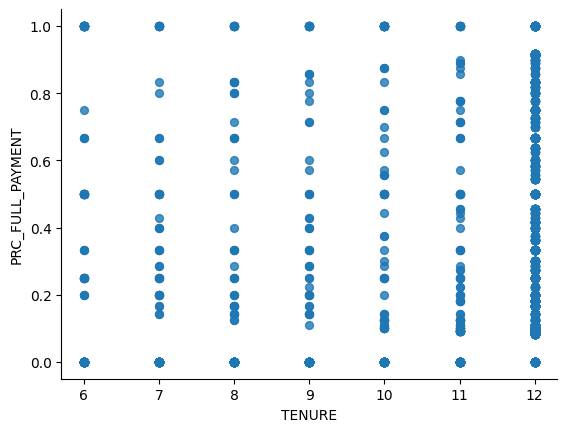

In [86]:
df.plot(kind='scatter', x='TENURE', y='PRC_FULL_PAYMENT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

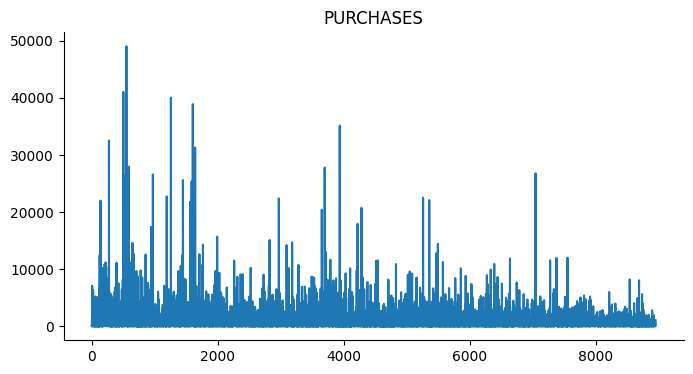

In [87]:
df['PURCHASES'].plot(kind='line', figsize=(8, 4), title='PURCHASES')
plt.gca().spines[['top', 'right']].set_visible(False)

## Finding the best number of clusaters 
To do this considering the selected variables the "Elbow Method" has been used

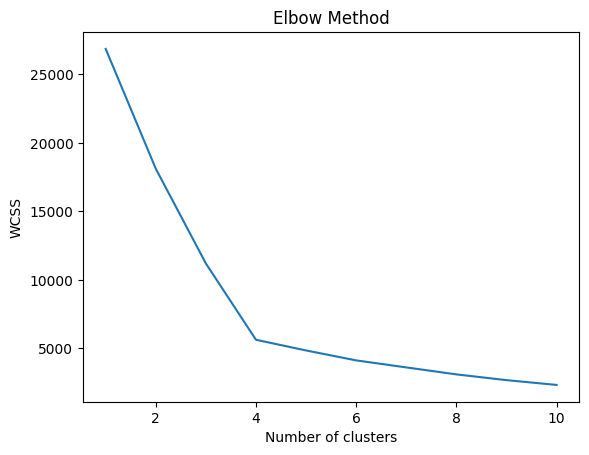

In [88]:
# Find the best number of clusters using elbow method for selected labes
df_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Step 2: Pre-process the data (example: standardization)
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Step 3: Apply the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_features_scaled)
    wcss.append(kmeans.inertia_)

# Step 4: Plotting to find the elbow point
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

So, optimal number of clusters are identified as 4.

## KMeans clustering
Here doing the KMeans clustering considering 4 cluters

In [89]:
X = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

# Assigning the cluster labels to your DataFrame as Loyalty_Category
df['Loyalty_Category'] = kmeans.labels_
labels = df['Loyalty_Category']

# Optionally, you might want to map numeric clusters to categorical labels
loyalty_mapping = {0: '0-Bronze', 1: '1-Silver', 2: '2-Gold', 3: '3-Platinum'}
df['Loyalty_Category'] = df['Loyalty_Category'].map(loyalty_mapping)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Loyalty_Category
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,2-Gold
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2-Gold
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0-Bronze
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,2-Gold
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,2-Gold


## Visualizing the number records for each category

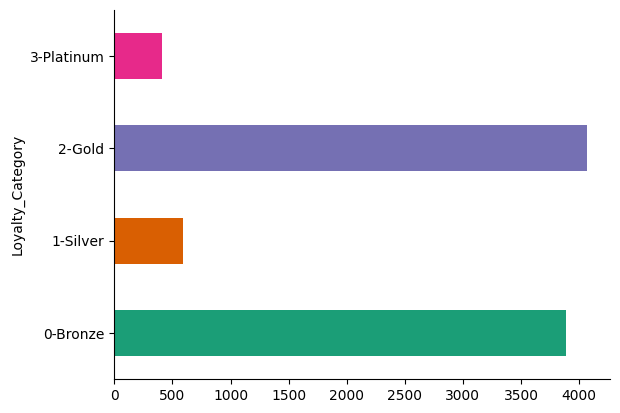

In [90]:
df.groupby('Loyalty_Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [91]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
Loyalty_Category                      0
dtype: int64

In [92]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(),inplace=True)
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean(),inplace=True)

In [93]:
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
Loyalty_Category                    0
dtype: int64

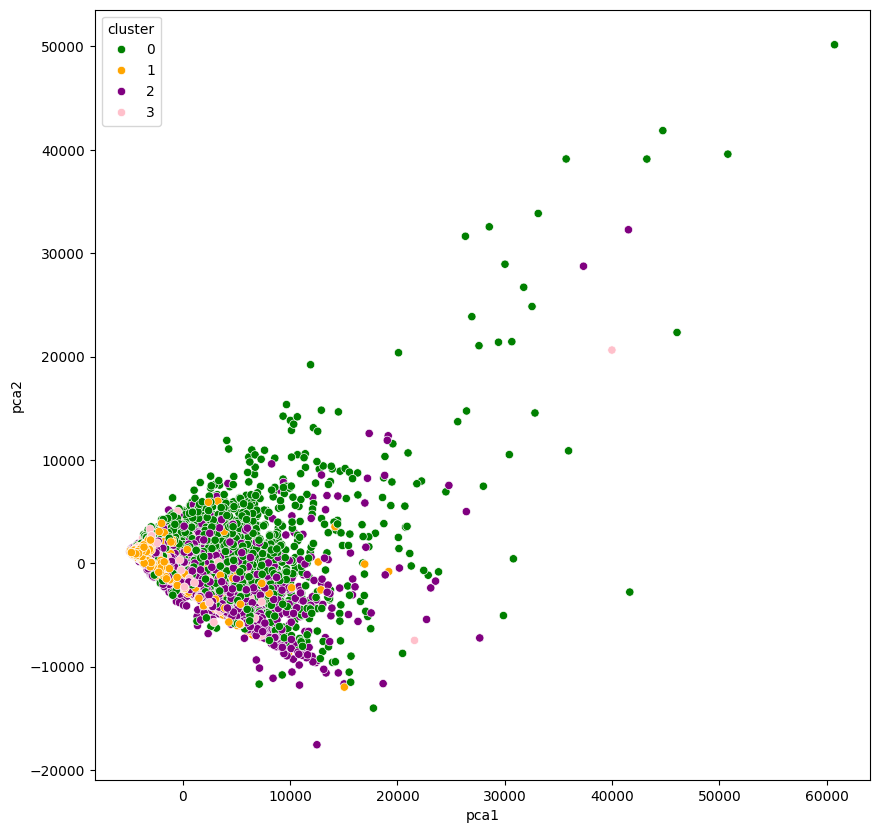

In [94]:
df1 = df.copy()
df1.drop("CUST_ID",axis=1,inplace=True)
loyalty_mapping2 = {'0-Bronze': 0,'1-Silver': 1,'2-Gold': 2,'3-Platinum': 3}

# Replace the string values with the corresponding numeric values
df1['Loyalty_Category'] = df1['Loyalty_Category'].replace(loyalty_mapping2)
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df1)
# principal_comp
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':df1['Loyalty_Category']})], axis = 1)
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['green','orange','purple','pink'])
plt.show()

## Check the Silhouette Score
This will show how much appropriate is it to clustering into 4 clusters

In [95]:
# Calculate the silhouette_score for the KMeans clustering we did and see the output

# Selecting only the relevant features for clustering
df_selected_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Impute missing values using the median for the selected features
imputer = SimpleImputer(strategy='median')
df_selected_imputed = imputer.fit_transform(df_selected_features)

# Standardize the selected features
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected_imputed)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_selected_scaled)

# Calculate the silhouette coefficient
silhouette_avg = silhouette_score(df_selected_scaled, clusters)

# Print the silhouette score
print("The average silhouette_score is :", silhouette_avg)

# Print the cluster assignments
print(clusters[:10])  # showing only the first 10 cluster assignments

The average silhouette_score is : 0.5846283649339238
[3 3 0 3 3 0 2 0 3 3]


So, a silhouette score of approximately 0.585 suggests that on average, objects are relatively well clustered. 
In other words, each data point is, on average, closer to the points in its own cluster than to points in other clusters, though there might still be some overlap or closely positioned clusters. 
This is generally a sign that the clustering configuration is fairly good and that the clusters are distinct from each other.

## Trying to do the clustering with the DBSCAN ALgorithem
Tried this also to see how will that be fit for the solution

In [96]:
#Trying to do clustering with DBSCAN
df_selected_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Impute missing values using the median for the selected features
imputer = SimpleImputer(strategy='median')
df_selected_imputed = imputer.fit_transform(df_selected_features)

# Standardize the selected features
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected_imputed)

# Apply DBSCAN clustering with determined parameters
# These parameters should be adjusted based on the specific dataset characteristics
dbscan = DBSCAN(eps=2.5, min_samples=34)
clusters_selected_features = dbscan.fit_predict(df_selected_scaled)

# Count the number of clusters and noise points
n_clusters_selected_features = len(set(clusters_selected_features)) - (1 if -1 in clusters_selected_features else 0)
n_noise_selected_features = list(clusters_selected_features).count(-1)

# Prepare the results in a new DataFrame for better visualization
result_df_selected_features = pd.DataFrame({
    'CUST_ID': df['CUST_ID'],
    'CLUSTER': clusters_selected_features
})

print("Number of clusters:", n_clusters_selected_features)
print("Number of noise points:", n_noise_selected_features)
print(result_df_selected_features.head())

Number of clusters: 1
Number of noise points: 0
  CUST_ID  CLUSTER
0  C10001        0
1  C10002        0
2  C10003        0
3  C10004        0
4  C10005        0


This gives only one clusters. 
So, decided to ignore DBSCAN for this and go with the KMeans approach

## Do extended cleaning removing the outliers also.

In [97]:
def do_extended_cleaning(df):

    df1 = df.copy()
    df1.drop("CUST_ID",axis=1,inplace=True)

    # df1.dropna()
    # df1.drop_duplicates()

    # Remove outliers
    for i in df1:
      Q1 = df1[i].quantile(0.25)
      Q3 = df1[i].quantile(0.75)
      IQR = Q3 - Q1
      up_lim = Q3 + 1.5 * IQR
      low_lim = Q1 - 1.5 * IQR
      df1.loc[df1[i] > up_lim,i] = up_lim
      df1.loc[df1[i] < low_lim,i] = low_lim

    df1.dropna()
    df1.drop_duplicates(inplace=True)
    
    return df1

## Recheck with different data cleaning approach
Here we loaded data again to recheck clustering with extended data cleaning and other techniques to see whether we can refine further

In [98]:
df = do_extended_cleaning(pd.read_csv('sample_data/marketing_data.csv'))
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.722223,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Normalizing and scaling data
Here we do normalizing and scaling data and then visualize it to understand how it has been cleared out

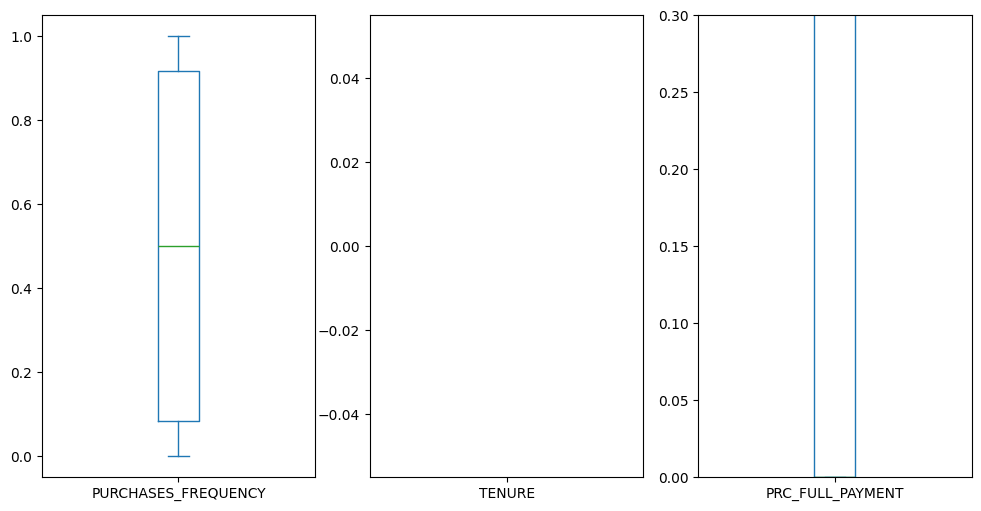

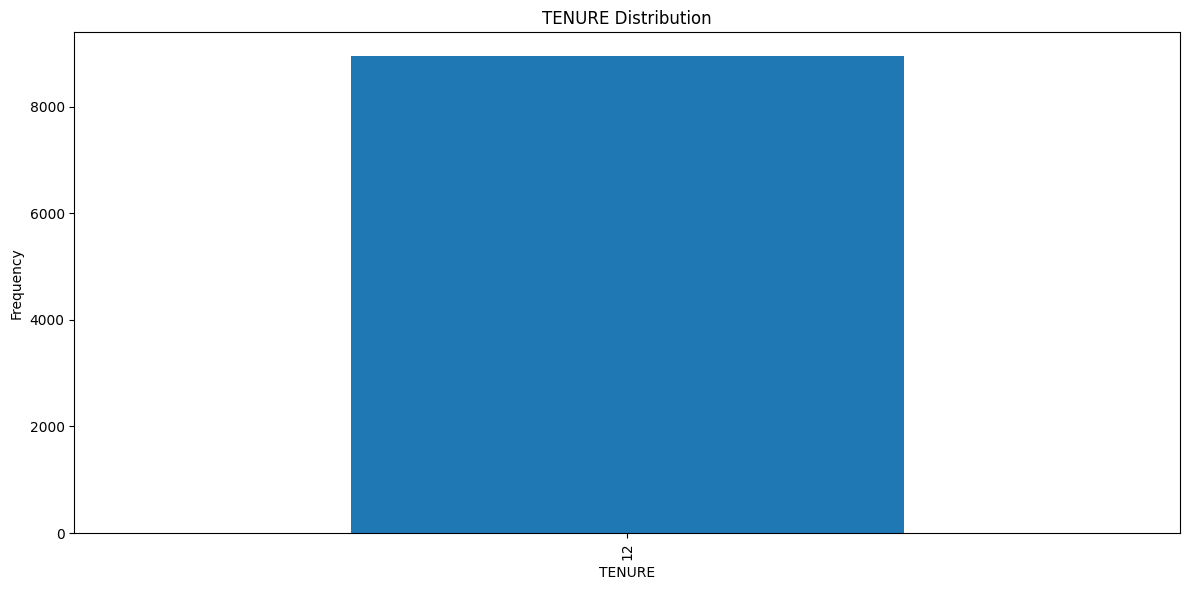

In [99]:
df_scaled = (df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']] - df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].min()) / (df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].max() - df[['PURCHASES_FREQUENCY', 'TENURE', 'PRC_FULL_PAYMENT']].min())

# Plotting scaled data
df_scaled.plot(kind='box', subplots=True, layout=(1,3), figsize=(12, 6))

# Adjusting ylim if necessary (example for 'PRC_FULL_PAYMENT')
plt.subplot(1, 3, 3) # Adjust the index accordingly
plt.ylim(0, 0.3) # Set the limit to focus on the main cluster of data

# If TENURE is a discrete variable, you might want to plot it differently:
plt.figure(figsize=(12, 6))
df['TENURE'].value_counts().plot(kind='bar')
plt.title('TENURE Distribution')
plt.xlabel('TENURE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

This one has understood the all the non 12 values as outliers and eliminated them

## More clearning
Here we check the columns has NaN values after do above extended claening

In [100]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

So, you can see minimum payment and credit limits are needed to be clened further.
Let's clean them and do a nother recheck.

In [101]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(),inplace=True)
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean(),inplace=True)

In [102]:
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

<Axes: >

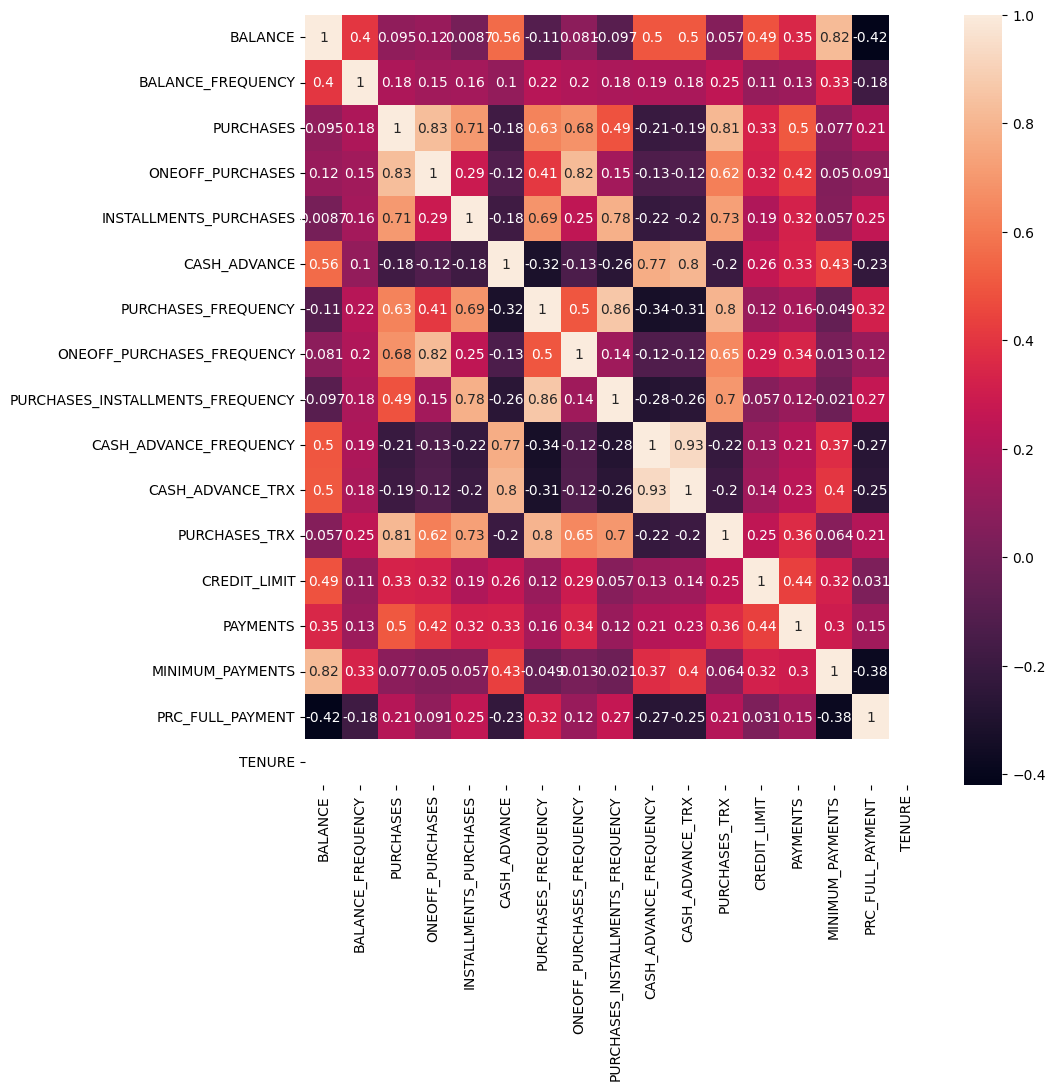

In [103]:
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df.corr(), annot=True)

## Apply elbow method again
Now let's see how many clusters can we create for that using elbow method

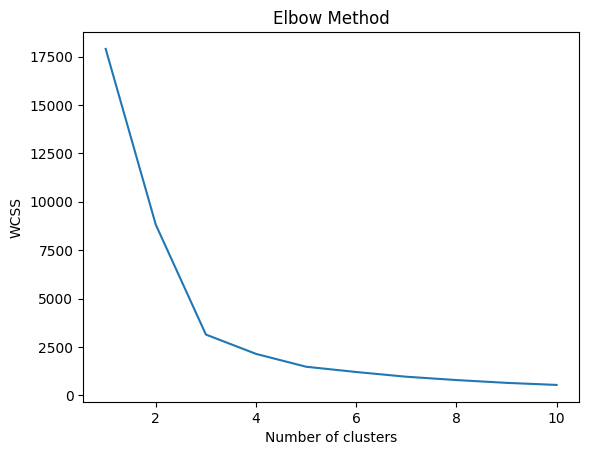

In [104]:
df_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Step 2: Pre-process the data (example: standardization)
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Step 3: Apply the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_features_scaled)
    wcss.append(kmeans.inertia_)

# Step 4: Plotting to find the elbow point
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

So, as per the above digram it can be seen as 3. 
That means most probably, outlier removing has merged seperate cluster in to another.

## Apply KMeans clustering to K=3
Here we apply the KMeans algorithem selecting the number of clusters as 3

In [105]:
X = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Assigning the cluster labels to your DataFrame as Loyalty_Category
df['Loyalty_Category'] = kmeans.labels_

# Optionally, you might want to map numeric clusters to categorical labels
loyalty_mapping = {0: '0-Silver', 1: '1-Gold', 2: '2-Platinum'}
df['Loyalty_Category'] = df['Loyalty_Category'].map(loyalty_mapping)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Loyalty_Category
0,40.900749,0.818182,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1-Gold
1,3202.467416,0.909091,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1-Gold
2,2495.148862,1.000000,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0-Silver
3,1666.670542,0.722223,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,574.591399,0.000000,12,1-Gold
4,817.714335,1.000000,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1-Gold


## Visualize the clustered data in bar chart

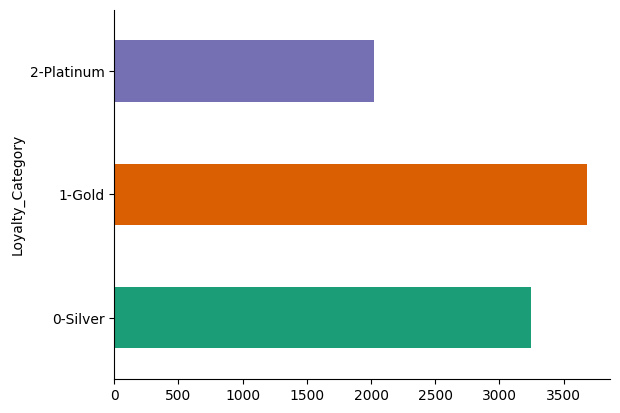

In [106]:
df.groupby('Loyalty_Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [107]:
# Selecting only the relevant features for clustering
df_selected_features = df[['PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']]

# Impute missing values using the median for the selected features
imputer = SimpleImputer(strategy='median')
df_selected_imputed = imputer.fit_transform(df_selected_features)

# Standardize the selected features
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected_imputed)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_selected_scaled)

# Calculate the silhouette coefficient
silhouette_avg = silhouette_score(df_selected_scaled, clusters)

# Print the silhouette score
print("The average silhouette_score is :", silhouette_avg)

# Print the cluster assignments
print(clusters[:10])  # showing only the first 10 cluster assignments

The average silhouette_score is : 0.6002381021812511
[2 2 3 2 2 0 1 3 0 2]


## Visualize it further 
This is to see how the clusters are organized compared to each others

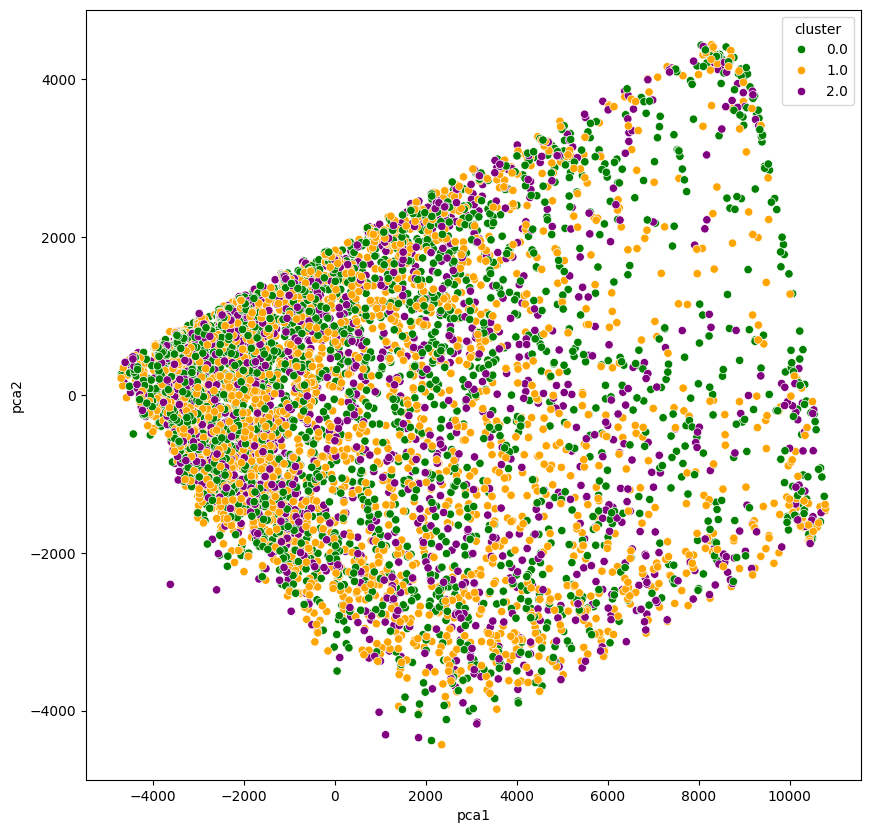

In [108]:
df1 = df.copy()
df1.dropna()
loyalty_mapping2 = {'0-Silver': 0,'1-Gold': 1,'2-Platinum': 2}

# Replace the string values with the corresponding numeric values
df1['Loyalty_Category'] = df1['Loyalty_Category'].replace(loyalty_mapping2)
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df1)
# principal_comp
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':df1['Loyalty_Category']})], axis = 1)
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['green','orange','purple'])
plt.show()

So as a sumary,
A silhouette score of 0.58 for 4 clusters and 0.60 for 3 clusters indicates that, on average, data points are slightly better matched to their own cluster and more distinct from neighboring clusters when the data is partitioned into 3 clusters as opposed to 4.

In general, the higher the silhouette score, the better the clustering configuration, because it suggests a clearer structure where clusters are well-separated and cohesive. Therefore, based on the silhouette scores alone, partitioning the data into 3 clusters would be considered better than partitioning it into 4 clusters in this case.

So, we decided to go with three clusters. (eg : Silver, Gold, and Platinum)